In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd

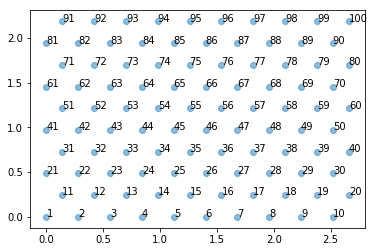

In [2]:
# N must be even and this will make a lattice with N points in x and N points in y directions

N = 10
d = 0.28

# set up square mesh

nx, ny = (N, N)
x = np.linspace(0, N-1, nx)*d
y = np.linspace(0, N-1, ny)*d
xv, yv = np.meshgrid(x, y)
xv_array = np.asarray(xv).reshape(-1)
yv_array = np.asarray(yv).reshape(-1)

# scaling for hexagonal points (in y)
y_scale = np.sqrt(3)/2
yv_hex = yv_array*y_scale

# shift for hexagonal points (in x) - for every second row, bump a bit to the right
no_shift = np.zeros((N))
yes_shift = np.ones((N))*d/2

# vector that contains shifts for x coordinate every second row in lattice
x_shift = np.concatenate((no_shift, yes_shift), axis=0)

xv_hex = xv_array + np.tile(x_shift, N//2)

coordinates_hex = np.vstack((xv_hex, yv_hex))

plt.scatter(coordinates_hex[0,:],coordinates_hex[1,:], alpha = 0.5)

for i in range(N**2):
    plt.text(coordinates_hex[0,i],coordinates_hex[1,i], str(i+1))

plt.show()

In [3]:
def neighbour(a):
    '''return neigbouring sites of a lattice position, allows infinite boundary condition'''   
    x_even = np.linspace(0.5, N-0.5, nx)*d
    x_even = np.around(x_even, 2)
    x_odd = np.around(x, 2)
    sites = np.array([])
    
    def corners(a):
        '''checks if position is located at one of the corners'''
        c_sites = np.array([])
        # e.g. for 10x10 lattice
        # checks for lattice point 1
        if a == 0:
            c_sites = np.append(c_sites, [a+N-1, a+2*N-1, a+N, a+1, N**2-(N-a), N**2-1])
        # checks for lattice point 10
        if a == N-1:
            c_sites = np.append(c_sites, [a-1, a+N-1, a+N, a-N+1, N**2-1,  (N**2-1)-(N-a)])
        # checks for lattice point 91
        if a == N**2-N:
            c_sites = np.append(c_sites, [a+N-1, N-(N**2-a), N-(N**2-a)+1, a+1, a-N+1,  a-N])
        # checks for lattice point 100
        if a == N**2-1:
            c_sites = np.append(c_sites, [a-1, N-(N**2-a), 1, a-N+1, a-2*N+1, a-N])
        
        return c_sites
    
    def flcol(a):
        '''checks if position is located at the vertical sides'''
        value = round(xv_hex[a], 2)
        s_sites = np.array([])
        # for left edge of lattice
        if a%N == 0:
            if value in x_odd: 
                s_sites = np.append(s_sites, [a+N-1, a+2*N-1, a+N, a+1, a-N, a-1])
            elif value in x_even:   
                s_sites = np.append(s_sites, [a+N-1, a+N, a+N+1, a+1, a-N+1, a-N])
        # for right edge of lattice
        if (a+1)%N == 0:
            if value in x_odd:
                s_sites = np.append(s_sites, [a-1, a+N-1, a+N, a-N+1, a-N, a-N-1])
            elif value in x_even:
                s_sites = np.append(s_sites, [a-1, a+N, a+1, a-N+1, a-2*N+1, a-N])
        
        return s_sites
     
    def flrow(a):
        '''checks if position is located at the horizontal sides'''
        r_sites = np.array([])
        # for bottom edge of lattice
        if a in np.arange(0,N):
            r_sites = np.append(r_sites, [a-1, a+N-1, a+N, a+1, N**2-(N-a), N**2-(N-a)-1])
        # for top edge of lattice
        if a in np.arange(N**2-N, N**2):
            r_sites = np.append(r_sites, [a-1, N-(N**2-a), N-(N**2-a)+1, a+1, a-N+1, a-N])
        
        return r_sites
    
    def mid(a):
        '''checks if position is on "odd" row or "even" row'''
        value = round(xv_hex[a], 2)
        m_sites = np.array([])
        if value in x_odd:
            m_sites = np.append(m_sites, [a-1, a+N-1, a+N, a+1, a-N, a-N-1])
        if value in x_even:
            m_sites = np.append(m_sites, [a-1, a+N, a+N+1, a+1, a-N+1, a-N])
        return m_sites
    
    if len(corners(a))!= 0:
        sites = np.append(sites, corners(a))
        return sites
    elif len(flcol(a))!= 0:
        sites = np.append(sites, flcol(a))
        return sites
    elif len(flrow(a))!= 0:
        sites = np.append(sites, flrow(a))
        return sites
    else:
        sites = np.append(sites, mid(a))
        return sites

In [4]:
class Simulation:
    
    def __init__(self, E_act, noise, temp, E_field):
        # activation energy
        self.active = E_act
        # noise in system
        self.disorder = noise
        # initiation point
        self.start = 31
        # applied field
        self.applied = E_field
        
        # angle between points and effect on external field
        angle = 60/180*np.pi
        self.field = E_field * np.array([1, np.cos(angle), -np.cos(angle), -1, -np.cos(angle), np.cos(angle)])
        self.xdist = np.array([-d, -d/2, d/2, d, d/2, -d/2])
        self.ydist = np.array([0, np.sqrt(3)/2*d, np.sqrt(3)/2*d, 0, -np.sqrt(3)/2*d, -np.sqrt(3)/2*d])
        kB = 8.617332e-5
        self.kT = kB * temp
        
        #track position
        self.hops = []

    
    def factor(self):
        '''returns pre-exponential factor for hopping rate '''
        return 2 * self.kT / 4.1357e-15
    
    def kmc(self):
        '''returns mean squared total displacement at set time intervals '''
        E = np.random.uniform(-0.1, 0.1, (N**2))
        # choosing a random lattice point in the centre of lattice
        #a = np.random.randint(2*N,N**2-2*N)
        a = self.start
        # construct table
        df = pd.DataFrame([])
        
        tot_xdist = 0
        tot_ydist = 0
        
        time = 0 
        
        # keep tracks of time
        x_time = np.array([])
        # record mean squared displacement
        y_msd = np.array([])
        
        # simulation runs until number of hops is reached
        for i in range(500):
            if self.disorder != 0:
                dE = np.array([])
                # retrieve neigbouring points from neigbour function
                for i in neighbour(a):
                    i = i.astype(int)
                    # adds noise to activation energy
                    dE = np.append(dE, E[i]*self.disorder + self.active)
            else:
                # condition when no noise is introduced to the system
                dE = np.ones(6)*self.active
                
            # can include electric field if needed 
            if self.applied != 0:
                E_tot = dE - d*self.field
            else:
                E_tot = dE

            # rate of hopping
            v = self.factor()*np.exp(-E_tot/self.kT)
            # generate random number
            Randnum1 = random.uniform(0,1) 
            # set position of pointer
            rk = Randnum1 * np.sum(v)
            # cumulative sum of energy
            k = np.cumsum(v)
            
            # going through k1, k1+k2...., ktotal
            for i in np.nditer(k):
            # if value smaller than pointer choose path
                if i > rk:
                    next_step = list(k).index(i)
                    break
            # generate second random number
            Randnum2 = random.uniform(0,1)
            # increment time for each step
            time = time +(-1/np.sum(v)) * np.log(Randnum2)
            # update a for new lattice site
            a = (neighbour(a)[next_step]).astype(int)
            # calculate total displacement in the x and y direction
            tot_xdist += self.xdist[next_step]
            tot_ydist += self.ydist[next_step]
            # calculate total displacement
            tot_dis = np.sqrt(np.square(tot_xdist)+np.square(tot_ydist))
            
            # for every time increment, output time and mean square displacement
            x_time = np.append(x_time, time)
            y_msd = np.append(y_msd,np.square(tot_dis))
        data = pd.DataFrame({'time,s': x_time, 'MSD,nm^2': y_msd})
        return data
        

In [5]:
class Calc:
    
    def __init__(self, x, y):
        '''x and y are time and MSD from simulation'''
        self.data = x
        self.target = y*(10**-7)**2
        # degrees of freedom
        self.df = len(y)-2
        self.z = np.polyfit(x, y*(10**-7)**2, 1)
        self.p = np.poly1d(self.z)
    
    def plot(self):
        '''returns array to construct plot for linear fitting'''
        return self.p(self.data)
    
    def diff_coeff(self):
        slope, intercept = self.z
        return slope/ 4
        
    def ssx(self):
        '''returns sum of squared difference of x'''
        mean_x = np.mean(self.data)
        squared_diff = np.square(self.data-mean_x)
        return np.sum(squared_diff)
    
    def sse(self):
        '''error sum of squares'''
        squared_diff = np.square(self.target-self.plot())
        return np.sum(squared_diff)
    
    def var(self):
        '''standard deviation of gradient'''
        # variance of y(x)
        v_y = self.sse()/self.df
        # variance of gradient
        v_g = v_y/ self.ssx()
        return v_g

In [6]:
class Stats:
    # calculates weighted average of diffusion coefficient and its standard error from large number of runs
    # arg: arrays
    def __init__(self, x, y):
        self.df = x
        self.var = y
        # returns reciprocal of variance 
        self.rec = 1/y
        
    def w_mean(self):
        '''returns weighted average'''
        mean = np.sum(np.multiply(self.df, self.rec))/np.sum(self.rec)
        return mean
    
    def error(self):
        '''returns standard error of average'''
        std_error = np.sqrt(1/np.sum(self.rec))
        return std_error

In [10]:
'''tune disorder'''
dis = np.array([1.6, 1.7, 1.8, 1.9, 2])
df_mean = np.array([])
df_err = np.array([])
MSD_vs_t = pd.DataFrame([])
for m in np.nditer(dis):
    record = pd.DataFrame([])
    col_df = np.array([])
    col_var = np.array([])
    for h in range(1500):
        run = Simulation(0.249, m, 300, 0)
        data = run.kmc()
        record = pd.concat([record, data], axis=1, sort=False)
        
        # calculate diffusion coefficient and variance from plot
        result = Calc(data['time,s'], data['MSD,nm^2'])
        df = result.diff_coeff()
        col_df = np.append(col_df, df)
        variance = result.var()
        col_var = np.append(col_var, variance)
    
    # calculate weighted average of diffusion coefficient and standard error 
    analysis = Stats(col_df, col_var)
    mean = analysis.w_mean()
    std_err = analysis.error()
    
    df_mean = np.append(df_mean, mean)
    df_err = np.append(df_err, std_err)
        
    MSD = record.iloc[:, 1::2]
    time = record.iloc[:, 0::2]
    MSD_mean = MSD.mean(axis=1)
    time_mean = time.mean(axis=1)
    MSD_std = MSD.std(axis=1)
    std_err_plot = MSD_std/np.sqrt(1500)
    
    MSD_vs_t = pd.concat([MSD_vs_t, time_mean, MSD_mean, std_err_plot], axis=1)
    
    
    
        

In [11]:
table = pd.DataFrame({'disorder, eV': dis/10,'diffusion coefficient, $cm^2s^-1$': df_mean, 'error': df_err})
table

,"disorder, eV","diffusion coefficient, $cm^2s^-1$",error
0,0.16,3.221430e-09,3.086777e-10
1,0.17,1.005123e-23,2.137298e-23
2,0.18,-4.607896e-23,1.895688e-23
3,0.19,-2.647984e-22,7.687820e-23
4,0.20,-6.154810e-24,7.478186e-24


In [18]:
dis = np.arange(0.0, 0.17, 0.01)
diff = np.array([0.0000003601639,0.0000003310832, 0.000000342768, 0.0000003349739, 0.0000002838473, 0.0000002838041, 0.0000002194556, 0.0000002016134, 0.0000001716749, 0.0000001211415, 0.00000003811819, 0.0000000854991, 0.00000004782875, 0.0000000555482, 0.00000001328119, 0.000000003539209, 0.00000000322143])

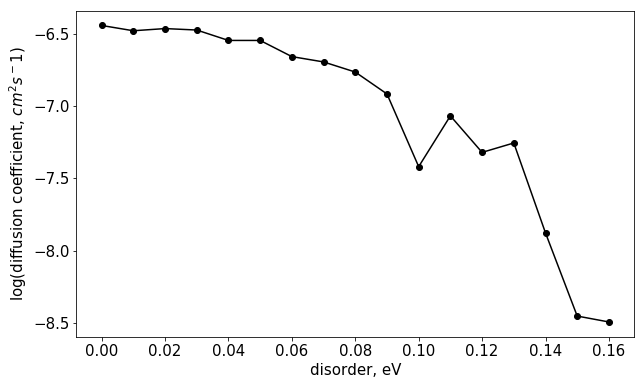

In [19]:

# block for plotting
plt.figure(figsize=(10,6))
x = dis
y = diff
z = np.log10(y)

plt.plot(x, z, color ='k', marker = 'o' )

plt.xlabel('disorder, eV', fontsize=15)
plt.ylabel('log(diffusion coefficient, $cm^2s^-1$)', fontsize=15)
plt.rcParams['font.size'] = 15
plt.rc('xtick', labelsize = 15)
plt.rc('xtick', labelsize = 15)
plt.savefig('MSD_vs_time_noise.pdf')
plt.show()
plt.close()

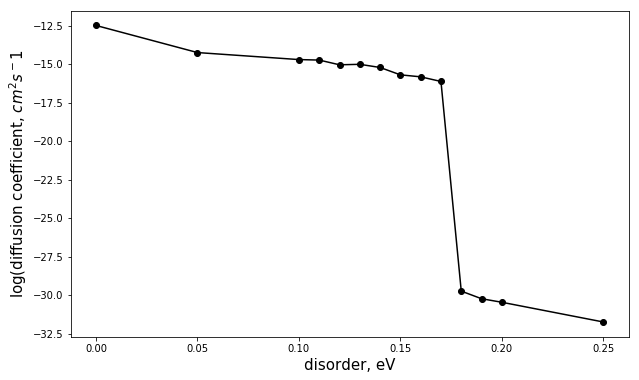

In [9]:
# block for plotting
plt.figure(figsize=(10,6))
x = np.array([0, 0.05, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2, 0.25])
y = np.array([0.000000000000320607, 5.590639e-15, 1.959307e-15, 1.819832e-15, 8.986683e-16, 9.647787e-16, 6.020838e-16, 2.003675e-16, 1.487648e-16, 7.447717e-17, 1.84692e-30, 5.922368e-31, 3.487722e-31,  1.833842e-32])
z = np.log10(y)

plt.plot(x, z, color ='k', marker = 'o' )

plt.xlabel('disorder, eV', fontsize=15)
plt.ylabel('log(diffusion coefficient, $cm^2s^-1$', fontsize=15)
plt.rcParams['font.size'] = 15
plt.rc('xtick', labelsize = 15)
plt.rc('xtick', labelsize = 15)
plt.savefig('MSD_vs_time_noise.pdf')
plt.show()
plt.close()

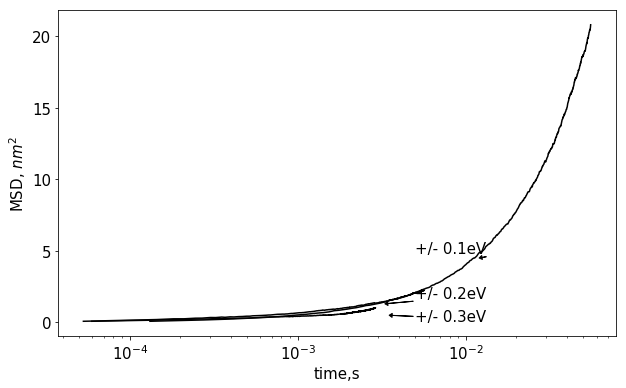

In [13]:
plt.figure(figsize=(10,6))

plt.semilogx(MSD_vs_t.iloc[:, 0], MSD_vs_t.iloc[:, 1], color = 'k')
plt.semilogx(MSD_vs_t.iloc[:, 3], MSD_vs_t.iloc[:, 4], color = 'k')
plt.semilogx(MSD_vs_t.iloc[:, 6], MSD_vs_t.iloc[:, 7], color = 'k')
plt.annotate('+/- 0.1eV',xy = (12e-3, 4.5), xytext =(5e-3, 4.8), arrowprops=dict(facecolor='black', width=0.1, headwidth = 4, headlength = 3), fontsize=15)
plt.annotate('+/- 0.2eV',xy = (3.3e-3, 1.3), xytext =(5e-3, 1.7), arrowprops=dict(facecolor='black', width=0.1, headwidth = 4, headlength = 3), fontsize=15)
plt.annotate('+/- 0.3eV',xy = (3.5e-3, 0.5), xytext =(5e-3, 0.1), arrowprops=dict(facecolor='black', width=0.1, headwidth = 4, headlength = 3), fontsize=15)
plt.xlabel('time,s', fontsize=15)
plt.ylabel('MSD, $nm^2$', fontsize=15)
plt.rcParams['font.size'] = 15
plt.rc('xtick', labelsize = 15)
plt.rc('xtick', labelsize = 15)
plt.savefig('MSD_vs_time_noise.pdf')
plt.show()
plt.close()


In [7]:
'''varying temperature'''
temp = np.array(range(100, 600, 100))
df_mean1 = np.array([])
df_err1 = np.array([])
MSD_vs_t1 = pd.DataFrame([])
for k in np.nditer(temp):
    record1 = pd.DataFrame([])
    col_df1 = np.array([])
    col_var1 = np.array([])
    for p in range(1500):
        run1 = Simulation(0.7, 0, k, 0)
        data1 = run1.kmc()
        record1 = pd.concat([record1, data1], axis=1, sort=False)
        result1 = Calc(data1['time,s'], data1['MSD,nm^2'])
        df1 = result1.diff_coeff()
        col_df1 = np.append(col_df1, df1)
        variance1 = result1.var()
        col_var1 = np.append(col_var1, variance1)
        rec_var1 = 1/col_var1
    MSD1 = record1.iloc[:, 1::2]
    time1 = record1.iloc[:, 0::2]
    MSD_mean1 = MSD1.mean(axis=1)
    time_mean1 = time1.mean(axis=1)
    MSD_std1 = MSD1.std(axis=1)
    std_err_plot1 = MSD_std1/np.sqrt(1500)
    
    MSD_vs_t1 = pd.concat([MSD_vs_t1, time_mean1, MSD_mean1, std_err_plot1], axis=1)
    
    w_mean1 = np.sum(np.multiply(col_df1, rec_var1))/np.sum(rec_var1)
    std_err1 = np.sqrt(1/np.sum(rec_var1))
    df_mean1 = np.append(df_mean1, w_mean1)
    df_err1 = np.append(df_err1, std_err1)
    

In [7]:
table1 = pd.DataFrame({'Temperature, K': np.array(range(100, 600, 100)),'diffusion coefficient, $cm^2$': df_mean1, 'error': df_err1})
table1

,"Temperature, K","diffusion coefficient, $cm^2$",error
0,100,1.157373e-33,6.395564e-36
1,200,2.959929e-18,1.677291e-20
2,300,4.497748e-13,2.710759e-15
3,400,2.123703e-10,1.207888e-12
4,500,8.294168e-09,4.888671e-11


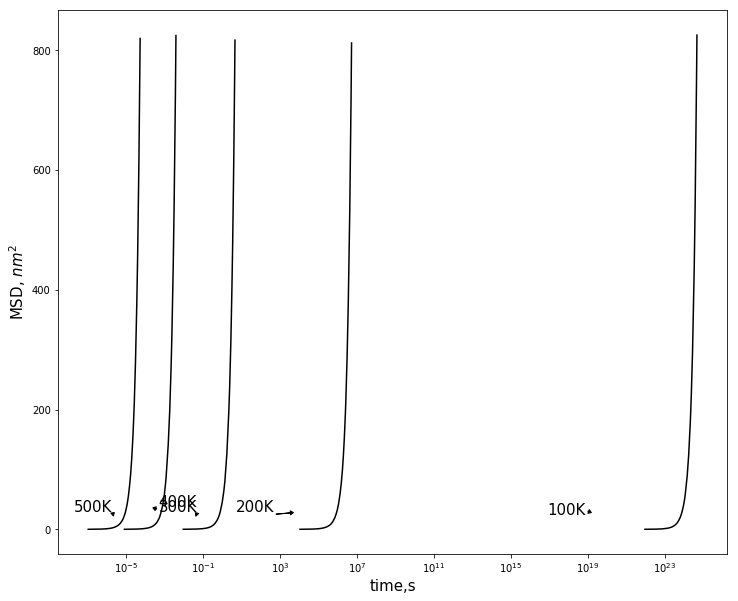

In [8]:
fig = plt.figure(figsize=(12, 10))
plt.semilogx(MSD_vs_t1.iloc[:, 0], MSD_vs_t1.iloc[:, 1], color = 'k')
plt.semilogx(MSD_vs_t1.iloc[:, 3], MSD_vs_t1.iloc[:, 4], color = 'k')
plt.semilogx(MSD_vs_t1.iloc[:, 6], MSD_vs_t1.iloc[:, 7], color = 'k')
plt.semilogx(MSD_vs_t1.iloc[:, 9], MSD_vs_t1.iloc[:, 10], color = 'k')
plt.semilogx(MSD_vs_t1.iloc[:, 12], MSD_vs_t1.iloc[:, 13], color = 'k')

plt.annotate('100K', xy = (15e18, 28), xytext =(0.8e17,24), arrowprops=dict(facecolor='black', width=0.1, headwidth = 4, headlength = 3), fontsize=15)
plt.annotate('200K', xy = (5e3, 28), xytext =(50e-1,30), arrowprops=dict(facecolor='black', width=0.1, headwidth = 4, headlength = 3), fontsize=15)
plt.annotate('300K', xy = (40e-3, 28), xytext =(50e-5,30), arrowprops=dict(facecolor='black', width=0.1, headwidth = 4, headlength = 3), fontsize=15)
plt.annotate('400K', xy = (25e-5, 36), xytext =(50e-5,38), arrowprops=dict(facecolor='black', width=0.1, headwidth = 4, headlength = 3), fontsize=15)
plt.annotate('500K', xy = (25e-7, 28), xytext =(20e-9,30), arrowprops=dict(facecolor='black', width=0.1, headwidth = 4, headlength = 3), fontsize=15)

plt.xlabel('time,s', fontsize=15)
plt.ylabel('MSD, $nm^2$', fontsize=15)
plt.rcParams['font.size'] = 15
plt.rc('xtick', labelsize = 15)
plt.rc('xtick', labelsize = 15)
plt.savefig('MSD_vs_time_temp.pdf')

plt.show()

In [ ]:
'''varying electric field'''
Ef = np.array([-0.05])
df_mean = np.array([])
df_err = np.array([])
MSD_vs_t = pd.DataFrame([])
for m in np.nditer(Ef):
    record = pd.DataFrame([])
    col_df = np.array([])
    col_var = np.array([])
    for h in range(1500):
        run = Simulation(0.18, 0, 298, m)
        data = run.kmc()
        record = pd.concat([record, data], axis=1, sort=False)
        result = Calc(data['time,s'], data['MSD,nm^2'])
        df = result.diff_coeff()
        col_df = np.append(col_df, df)
        variance = result.var()
        col_var = np.append(col_var, variance)
        rec_var = 1/col_var
    MSD = record.iloc[:, 1::2]
    time = record.iloc[:, 0::2]
    MSD_mean = MSD.mean(axis=1)
    time_mean = time.mean(axis=1)
    MSD_std = MSD.std(axis=1)
    std_err_plot = MSD_std/np.sqrt(1500)
    
    MSD_vs_t = pd.concat([MSD_vs_t, time_mean, MSD_mean, std_err_plot], axis=1)
    
    w_mean = np.sum(np.multiply(col_df, rec_var))/np.sum(rec_var)
    std_err = np.sqrt(1/np.sum(rec_var))
    df_mean = np.append(df_mean, w_mean)
    df_err = np.append(df_err, std_err)

In [13]:
table1 = pd.DataFrame({'electric field': Ef,'diffusion coefficient, $cm^2$': df_mean, 'error': df_err})
table1

,electric field,"diffusion coefficient, $cm^2$",error
0,-0.02,0.000051,9.730722e-08


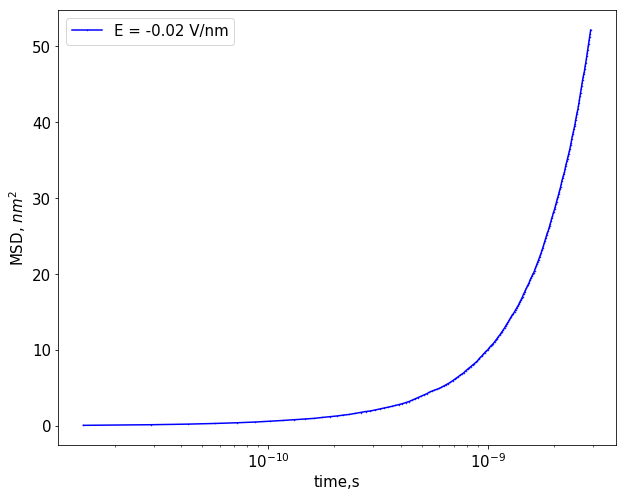

In [14]:
fig = plt.figure(figsize=(10, 8))
plt.semilogx(MSD_vs_t.iloc[0:200, 0], MSD_vs_t.iloc[0:200, 1], color = 'b', linestyle = '-', marker = 'o', ms = 0.5, label = 'E = -0.02 V/nm')
#plt.semilogx(MSD_vs_t.iloc[0:200, 3], MSD_vs_t.iloc[0:200, 4], color = 'r', linestyle = '-', marker = 'o', ms = 0.5, label = 'E = 0.02 V/nm')
#plt.semilogx(MSD_vs_t.iloc[0:200, 6], MSD_vs_t.iloc[0:200, 7], color = 'g', linestyle = '-', marker = 'o', ms = 0.5, label = 'E = 0.04 V/nm')
#plt.semilogx(MSD_vs_t.iloc[0:200, 9], MSD_vs_t.iloc[0:200, 10], color = 'y', linestyle = '-', marker = 'o', ms = 0.5, label = 'E = 0.06 V/nm')
#plt.semilogx(MSD_vs_t1.iloc[:, 12], MSD_vs_t1.iloc[:, 13], color = 'k')

#plt.annotate('0 V/nm', xy = (4e-3, 1.6), xytext =(0.6e-2, 0.5), arrowprops=dict(facecolor='black', width=0.1, headwidth = 4, headlength = 3), fontsize=15)
#plt.annotate('0.02 V/nm', xy = (4e-3, 2.3), xytext =(5.5e-3,4.5), arrowprops=dict(facecolor='black', width=0.1, headwidth = 4, headlength = 3), fontsize=15)
#plt.annotate('0.04 V/nm', xy = (5e-3, 5.4), xytext =(2e-3,10), arrowprops=dict(facecolor='black', width=0.1, headwidth = 4, headlength = 3), fontsize=15)
#plt.annotate('0.06 V/nm', xy = (7e-3, 15), xytext =(3e-3,20), arrowprops=dict(facecolor='black', width=0.1, headwidth = 4, headlength = 3), fontsize=15)
#plt.annotate('500K', xy = (25e-7, 28), xytext =(50e-9,30), arrowprops=dict(facecolor='black', width=0.1, headwidth = 4, headlength = 3))

plt.xlabel('time,s', fontsize=15)
plt.ylabel('MSD, $nm^2$', fontsize=15)
plt.rcParams['font.size'] = 15
plt.rc('xtick', labelsize = 15)
plt.rc('xtick', labelsize = 15)
plt.legend(loc='upper left')
#plt.savefig('MSD_vs_time_Efield.pdf')

plt.show()
plt.close()

In [7]:
'''varying activation energy'''
temp = np.array([0.4])
df_mean1 = np.array([])
df_err1 = np.array([])
MSD_vs_t1 = pd.DataFrame([])
for y in np.nditer(temp):
    record1 = pd.DataFrame([])
    col_df1 = np.array([])
    col_var1 = np.array([])
    for p in range(1500):
        run1 = Simulation(y, 0, 300, 0)
        data1 = run1.kmc()
        record1 = pd.concat([record1, data1], axis=1, sort=False)
        result1 = Calc(data1['time,s'], data1['MSD,nm^2'])
        df1 = result1.diff_coeff()
        col_df1 = np.append(col_df1, df1)
        variance1 = result1.var()
        col_var1 = np.append(col_var1, variance1)
        rec_var1 = 1/col_var1
    MSD1 = record1.iloc[:, 1::2]
    time1 = record1.iloc[:, 0::2]
    MSD_mean1 = MSD1.mean(axis=1)
    time_mean1 = time1.mean(axis=1)
    MSD_std1 = MSD1.std(axis=1)
    std_err_plot1 = MSD_std1/np.sqrt(1500)
    
    MSD_vs_t1 = pd.concat([MSD_vs_t1, time_mean1, MSD_mean1, std_err_plot1], axis=1)
    
    w_mean1 = np.sum(np.multiply(col_df1, rec_var1))/np.sum(rec_var1)
    std_err1 = np.sqrt(1/np.sum(rec_var1))
    df_mean1 = np.append(df_mean1, w_mean1)
    df_err1 = np.append(df_err1, std_err1)

In [8]:
table1 = pd.DataFrame({'Ea, eV': temp,'diffusion coefficient, $cm^2s^{-1}$': df_mean1, 'error': df_err1})
table1

,"Ea, eV","diffusion coefficient, $cm^2s^{-1}$",error
0,0.4,4.282457e-08,5.125838e-11
